## Processing handwritten equation with OpenCV and pytesseract

The goal of this project is to make an app which would be able to detect handwritten math symbols on a picture. After detecting math symbols the app should be able to solve simple mathematical problem given on a picture (addition, subtraction, multiplication and divison).

In [1]:
# import useful libraries
import os
import re
import cv2
import imutils
import argparse
import pytesseract
import numpy as np
import sympy
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
pytesseract. get_tesseract_version() 

<Version('5.3.1.20230401')>

In [3]:
# path to the main dataset directory
main_path = Path('D:\FormulaDecoder\sample_pics')
file_paths = []

# iterate through all files in the folder
for file_path in main_path.glob('**/*'):
    if file_path.is_file():
        file_paths.append(str(file_path))

# print the list of file paths
print(file_paths)

['D:\\FormulaDecoder\\sample_pics\\1.png', 'D:\\FormulaDecoder\\sample_pics\\10.png', 'D:\\FormulaDecoder\\sample_pics\\11.png', 'D:\\FormulaDecoder\\sample_pics\\12.png', 'D:\\FormulaDecoder\\sample_pics\\13.png', 'D:\\FormulaDecoder\\sample_pics\\14.png', 'D:\\FormulaDecoder\\sample_pics\\2.png', 'D:\\FormulaDecoder\\sample_pics\\3.png', 'D:\\FormulaDecoder\\sample_pics\\4.png', 'D:\\FormulaDecoder\\sample_pics\\5.png', 'D:\\FormulaDecoder\\sample_pics\\6.png', 'D:\\FormulaDecoder\\sample_pics\\7.png', 'D:\\FormulaDecoder\\sample_pics\\8.png', 'D:\\FormulaDecoder\\sample_pics\\9.png']


Now, while we are currently capable of solving basic mathematical operations such as addition, division, subtraction, and multiplication, our desire to tackle more intricate tasks and functions continues to drive further development

In [4]:
# function for loading equation image

def load_image(path):
    """Loads image
    Args:
        path (str): path to image """
        
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    return img

In [5]:
def find_contours(path):
    """
    Finds all contours in a given picture.
    Args:
        path (str): path to image
    Returns:
        contours: Detected contours. Each contour is stored as a vector of points.
        hierarchy: Optional output vector, containing information about the image topology.
    """
    img = cv2.imread(path)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 100, 255, 0)
    return cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [6]:
def check_exponent(bounding_boxes):
    """Checks difference between vertical coordinate y among two bounding boxes.
    Args:
        bounding_boxes (list): bounding box to be used for comparison
    Returns:
        boolean: True if according to a condition exponent is recognized. Otherwise returns False."""
    
    main_anchor = bounding_boxes[0][1] + bounding_boxes[0][3]
    remaining_anchors = [(bounding_box[1]+bounding_box[3]) for bounding_box in bounding_boxes[1:]]
    
    mask = [False]
    
    is_exponent = None
    delta_y = None
    
    for anchor in remaining_anchors:
        
        if 0.3 < (anchor/main_anchor) < 0.7:
            is_exponent = True
        else:
            is_exponent = False
            
        mask.append(is_exponent)
        
    return mask

In [7]:
def parsing_equation_string(string): 
    """Parsing string equation on every equation element and saving it into list
    Args:
        string (str): equation string for parsing
    Returns:
        result (lst) : list of equation elements in sequential order
    """
    import re 
    
    # create a regular expression pattern to match numbers and mathematical operators
    pattern = r'(\d+|[+\-*/])'

    # find all matches of the pattern in the string and store the results in a list
    result = re.findall(pattern, string)
    
    return result

In [8]:
def overlapping_axes(coord1, delta1, coord2, delta2):
    """Checks wether 2 bounding boxes overlap over given axes
    Args:
        coord1 (int): start coordinate of axes for first bounding box
        delta1 (int): size of first bounding box along axes
        coord2 (int): coordinate of start axes for second bounding box
        delta2 (int): size of second bounding box along axes
    Returns:
        bool: true if they overlap else false
    """
    if coord1 <= coord2 + delta2 and coord1 >= coord2:
        return True
    if coord1 + delta1 <= coord2 + delta2 and coord1 + delta1 >= coord2:
        return True
    if coord2 <= coord1 + delta1 and coord2 >= coord1:
        return True
    if coord2 + delta2 <= coord1 + delta1 and coord2 + delta2 >= coord1:
        return True

    return False

In [9]:
def remove_overlapping_bounding_boxes(boundingRects):
    """Finds all contours and chooses ones that best contour given characters.
    Args:
        boundingRects (list): list of bounding boxes to check and remove if overlapping
    Returns:
        list: list of bounding boxes for filtered contours
    """

    # If 2 bounding boxes are overlapping, take the bigger one
    for i in range(len(boundingRects)):
        if boundingRects[i] is None:
            continue
        for j in range(i + 1, len(boundingRects)):
            if boundingRects[j] is None:
                continue
            x1, y1, width1, height1 = boundingRects[i]
            x2, y2, width2, height2 = boundingRects[j]

            if overlapping_axes(x1, width1, x2, width2) and overlapping_axes(y1, height1, y2, height2):
                if width1 * height1 > width2 * height2:
                    boundingRects[j] = None
                else:
                    boundingRects[i] = None
                    break

    return [bounding for bounding in boundingRects if bounding is not None]

In [10]:
def correct_bounding_boxes(bounding_boxes):
    """
    This function takes a list of bounding boxes and corrects the height of any
    bounding boxes where the width is much greater than the height, so that they
    become more square-like. The modification is done based on the center point
    of each bounding box.
    """
    corrected_boxes = []
    
    for box in bounding_boxes:
        x, y, w, h = box
        if w / h > 2:
            center_x = (2*x + w) / 2
            center_y = (2*y + h) / 2
            
            h = int(w+20)
            w = h
            x = int(center_x - (w / 2))
            y = int(center_y - (h / 2))
            
            
        corrected_boxes.append((x, y, w, h))
    
    return corrected_boxes

In [11]:
def check_exponent_2(bounding_boxes):
    """Checks difference between vertical coordinate y among two bounding boxes.
    Args:
        bounding_boxes (list): bounding box to be used for comparison
    Returns:
        boolean: True if according to a condition exponent is recognized. Otherwise returns False."""
    
    origin = (bounding_boxes[0][1])-10
    baseline = bounding_boxes[0][1]+bounding_boxes[0][3]+10
    remaining_anchors = [((bounding_box[1]+bounding_box[3]+10),bounding_box[2],bounding_box[3]) for bounding_box in bounding_boxes[1:]]
    mask = [False]
    
    is_exponent = None
    
    for anchor,w,h in remaining_anchors:
        
        if ((anchor-origin)/(baseline-origin) < 0.65 ) and (w/h < 1.2):
            is_exponent = True
        else:
            is_exponent = False
            
        mask.append(is_exponent)
        
    return mask


## Step 1: Image preprocessing

The first step of preprocessing is to smooth out the image and make it a binary image (black or white) for contour analysis.

In [12]:
#Some preprocessing functions

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

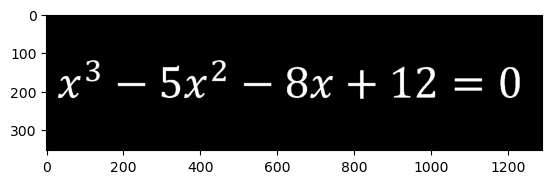

In [13]:
img = cv2.imread('D:\\FormulaDecoder\\sample_pics\\12.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#blur_img = cv2.GaussianBlur(gray, (5, 5),0)

# Apply binary thresholding
threshold_value = 127 # threshold value to be used
max_value = 255 # maximum value to be assigned for pixel values above threshold
threshold_type = cv2.THRESH_BINARY # binary thresholding type
_, binary = cv2.threshold(gray, threshold_value, max_value, threshold_type)

# Invert the image
inverted_img = cv2.bitwise_not(binary)

# Display the binary image
plt.imshow(inverted_img, cmap='gray')
plt.show()

We first apply a Gaussian blur to smooth out the image. We then use adaptive thresholding to binarize the image (make it black or white) and we then invert the colours since OpenCV uses black as the background and white as the objects.

## Step 2: Contour extraction

In [14]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        
    # handle if we are sorting against the y-coordinate rather than the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    # construct the list of bounding boxes and sort them from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

[False, True, False, False, False, True, False, False, False, False, False, False, False, False]


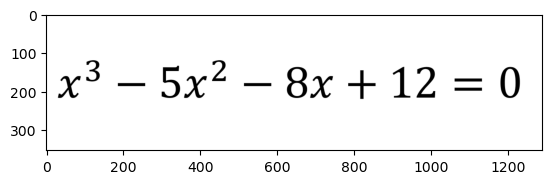

In [15]:
# Find contours in the thresholded image
contours, hierarchy = cv2.findContours(inverted_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

boundingRects=[cv2.boundingRect(contour) for contour in contours]
boundingRects.sort()

outputBoundingRects = []

# Combine rectangles for characters like "="
x_threshold = 5
i = 0

while i < len(boundingRects):
        
    if i == (len(boundingRects) - 1):  # last element
        
        outputBoundingRects.append(boundingRects[i])
        break
    
    else:
        x1, y1, w1, h1 = boundingRects[i]
        x2, y2, w2, h2 = boundingRects[i+1]
        center_x1 = (2*x1 + w1) / 2
        center_x2 = (2*x2 + w2) / 2
            
        if abs(center_x1 - center_x2) < x_threshold:
            # Combine the two bounding rects into one that takes up maximal space
            x = min(x1, x2)
            y = min(y1, y2)
            w = max(x1 + w1, x2 + w2) - x
            h = max(y1 + h1, y2 + h2) - y

            outputBoundingRects.append((x,y,w,h))
            i += 2  # skip next element

        else:
            outputBoundingRects.append(boundingRects[i])
            i += 1
            
outputBoundingRects = correct_bounding_boxes(outputBoundingRects)
"""      
# Draw bounding boxes around the contours
for (x, y, w, h) in outputBoundingRects:
    cv2.rectangle(img, (x-10, y-10), (x + w + 10, y + h + 10), (0, 255, 0), 2)
""" 
    
exponent = check_exponent_2(outputBoundingRects)
print(exponent)

plt.imshow(img, cmap='gray')
plt.show()


In [16]:
# Iterate through each bounding box and extract text using pytesseract
equation_parse=[]

for boundingBox in outputBoundingRects:
    
    # Get the bounding rectangle
    x, y, w, h = boundingBox
    
    # Extract text from the region of interest using pytesseract
    roi = inverted_img[y-10:y+h+10, x-10:x+w+10]
    roi = cv2.GaussianBlur(roi, (3, 3), 0)
    custom_config_1 = r'-c tessedit_char_whitelist=+-*/=Σ0123456789xyzO --psm 8 --oem 3'
   
    text = pytesseract.image_to_string(roi, config=custom_config_1 )
    text = text.rstrip('\n')
    equation_parse.append(text)

In [17]:
equation_parse

['x', '3', '-', '5', 'x', '2', '-', '8', 'x', '+', '1', '2', '=', '0']

In [18]:
exponent

[False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [19]:
eq = [(x, y) for x, y in zip(equation_parse, exponent)]
eq

[('x', False),
 ('3', True),
 ('-', False),
 ('5', False),
 ('x', False),
 ('2', True),
 ('-', False),
 ('8', False),
 ('x', False),
 ('+', False),
 ('1', False),
 ('2', False),
 ('=', False),
 ('0', False)]

## Step 3: Constructing equation for python to solve

For simple math (like addition, subtraction, multiplication and division) we will use built-in python function eval(). For more complex functions (like polynomial equations etc.) we must write algorithm for inputing such functions in mathematical modules (e.g. Sympy, Numpy, ect)

In [20]:
sympy_input = ""


for elem, is_exp in eq:
    if all(is_exp == False for is_exp in eq):
        
        if elem == "=":
            continue
            
        else:
            sympy_input += f'{elem}'
        
        # solve the equation
        result = round(eval(sympy_input), 5)
    else :
        continue


print(result) 

NameError: name 'result' is not defined

In [21]:
sol = sympy.solve('9+3')

In [22]:
print(sol)

[]


In [36]:
# Example input
eq_list = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]

def rewritting_equation(tuple_list):
    """Takes a list of tuples representing a mathematical equation and rewrites it as a string with exponentiation
        represented by double asterisks (i.e. **).
    Args:
        tuple_list(lst): A list of tuples representing a mathematical equation. Each tuple contains an element of the equation as a string and a boolean value indicating whether the element is an exponent or not.
    Returns
        string (str): returns the rewritten equation as a string.
    """
    # Step 1: Create an empty string variable
    equation = ""

    # Step 2: Iterate through the list of tuples
    for item in eq_list:
        # Step 2a: If the element is an exponent, append the element followed by "**" to equation
        if item[1]:
            equation += "**" + item[0] 
        # Step 2b: Otherwise, just append the element to equation
        else:
            # Step 2c: Check if the current element is a number and the next element is a variable
            if i < len(tuple_list) - 1 and tuple_list[i][0].isdigit() and not tuple_list[i+1][1]:
                equation += tuple_list[i][0] + "*"
                
            equation += item[0]

    return equation

eq=rewritting_equation(eq_list)
print(eq)
"""
# Step 3: Pass the equation string to Sympy simplify() function to simplify the expression
simplified_eq = sympy.simplify(equation)
print(simplified_eq)"""

x**3-5x**2-8x+12=0


'\n# Step 3: Pass the equation string to Sympy simplify() function to simplify the expression\nsimplified_eq = sympy.simplify(equation)\nprint(simplified_eq)'

In [33]:
#example
x = sympy.symbols('x')
eq = sympy.simplify('x**3 - 5*x**2 - 8*x + 12')
solution = sympy.solve(eq, x)

print(solution)


[-2, 1, 6]


In [31]:

# define the equation as a string
equation = '2*x + y = 0'

def sympy_symbol(equation):
    # find all the variables in the equation
    variables = set(re.findall(r'\b[a-zA-Z]+\b', equation))
    
    # create the symbols for the variables
    symbols = {}
    for var in variables:
        symbols[var] = sympy.symbols(var)

    # replace the variables in the equation with the symbols
    for var, symbol in symbols.items():
        equation = equation.replace(var, str(symbol))
    
    return symbols

symbols = sympy_symbol(equation)

for var, symbol in symbols.items():
    equation = sympy.sympify(equation)
    solution = sympy.solve(equation, symbol)
    print(solution)

SympifyError: Sympify of expression 'could not parse '2*x + y = 0'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)

In [ ]:
# Example input
eq_list1 = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]

eq_list2 = [('9', False), ('+', False), ('3', False), ('=', False)]

def is_polynomial(eq):
    """
    Determines if the input is a polynomial equation or not.
    Args:
        eq: list of tuples representing the equation
    Returns: 
        boolean: True if the input is a polynomial equation, False otherwise
    """
    # Loop through each element in the equation
    for el in eq:
        # Skip operands and other non-variable/non-numeric characters
        if el[0] in '+-*/^()=':
            continue
        
        # Check if there are any variables in the equation
        elif el[0].isalpha():
            return True
     
    # If none of the above conditions are met, then the equation is not a polynomial
    return False

In [ ]:
print(is_polynomial(eq_list1))
print(is_polynomial(eq_list2))

The idea is to use above function to determine if we will use sympy (for solving polynomial equations), or we will use python's built in math module (for solving basic math operations with numbers)

In [ ]:
print(type(sympy_symbol('x**3-5x**2-8x+12=0')['x']))
for var, symbol in symbols.items():
    print(type(var))
    print(type(symbol))

In [ ]:
equation = '5**3'
eq_list = [('5', False), ('3', True)]
eq_list1 = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]

if is_polynomial(eq_list1):
    print ('polynom')   
else:
    result = eval(equation)
    print(result)

In [ ]:
def nesto():
    a=['x', '3', '-', '5', 'x', '2', '-', '8', 'x', '+', '1', '2', '=', '0']
    b=[False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]
    
    return a,b

In [ ]:
ab = nesto()

In [ ]:
print(ab)

In [ ]:
print(b)

In [38]:
# Example input
eq_list = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]

def rewritting_equation(tuple_list):
    """Takes a list of tuples representing a mathematical equation and rewrites it as a string with exponentiation
        represented by double asterisks (i.e. **).
    Args:
        tuple_list(lst): A list of tuples representing a mathematical equation. Each tuple contains an element of the equation as a string and a boolean value indicating whether the element is an exponent or not.
    Returns
        string (str): returns the rewritten equation as a string.
    """
    # Step 1: Create an empty string variable
    equation = ""

    # Step 2: Iterate through the list of tuples
    for item in tuple_list:
        # Step 2a: If the element is an exponent, append the element with "**" in front to equation
        if item[1]:
            equation += "**" + item[0] 
        # Step 2b: Otherwise, just append the element to equation
        else:
            # Step 2c: Check if the current element is a number and the next element is a variable
            if i < len(tuple_list) - 1 and tuple_list[i][0].isdigit() and not tuple_list[i+1][1]:
                equation += tuple_list[i][0] + "*"
                
            equation += item[0]

    return equation

eq=rewritting_equation(eq_list)
print(eq)

x**3-5x**2-8x+12=0


In [39]:
# Example input
eq_list = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]
def rewritting_equation(tuple_list):
    """Takes a list of tuples representing a mathematical equation and rewrites it as a string with exponentiation
        represented by double asterisks (i.e. **). Inserts * between adjacent number and variable.
    Args:
        tuple_list(lst): A list of tuples representing a mathematical equation. Each tuple contains an element of the equation as a string and a boolean value indicating whether the element is an exponent or not.
    Returns
        string (str): returns the rewritten equation as a string.
    """
    # Step 1: Create an empty string variable
    equation = ""

    # Step 2: Iterate through the list of tuples
    for i in range(len(tuple_list)):
        # Step 2a: If the element is an exponent, append the element followed by "**" to equation
        if tuple_list[i][1]:
            equation += "**" + tuple_list[i][0]
        # Step 2b: Otherwise, just append the element to equation
        else:
            # Step 2c: Check if the current element is a number and the next element is a variable
            if i < len(tuple_list) - 1 and tuple_list[i][0].isdigit() and not tuple_list[i+1][1]:
                equation += tuple_list[i][0] + "*"
            equation += tuple_list[i][0]

    return equation

eq=rewritting_equation(eq_list)
print(eq)

x**3-5*5x**2-8*8x+1*12*2=0


In [40]:
# Example input
eq_list = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]
def rewritting_equation(tuple_list):
    """Takes a list of tuples representing a mathematical equation and rewrites it as a string with exponentiation
        represented by double asterisks (i.e. **). Inserts * between adjacent number and variable.
    Args:
        tuple_list(lst): A list of tuples representing a mathematical equation. Each tuple contains an element of the equation as a string and a boolean value indicating whether the element is an exponent or not.
    Returns
        string (str): returns the rewritten equation as a string.
    """
    # Step 1: Create an empty string variable
    equation = ""

    # Step 2: Iterate through the list of tuples
    for i in range(len(tuple_list)):
        # Step 2a: If the element is an exponent, append the element followed by "**" to equation
        if tuple_list[i][1]:
            equation += "**" + tuple_list[i][0]
        # Step 2b: Otherwise, just append the element to equation
        else:
            # Step 2c: Check if the current element is a number and the next element is a variable
            if i < len(tuple_list) - 1 and tuple_list[i][0].isdigit() and not tuple_list[i+1][1] and tuple_list[i+1][0] not in '+-*/^()':
                equation += tuple_list[i][0] + "*"
            equation += tuple_list[i][0]

    return equation

eq=rewritting_equation(eq_list)
print(eq)

x**3-5*5x**2-8*8x+1*12*2=0


In [49]:
def rewritting_equation(tuple_list):
    """Takes a list of tuples representing a mathematical equation and rewrites it as a string with exponentiation
        represented by double asterisks (i.e. **). Inserts * between adjacent number and variable.
    Args:
        tuple_list(lst): A list of tuples representing a mathematical equation. Each tuple contains an element of the equation as a string and a boolean value indicating whether the element is an exponent or not.
    Returns
        string (str): returns the rewritten equation as a string.
    """
    # Step 1: Create an empty string variable
    equation = ""

    # Step 2: Iterate through the list of tuples
    for i in range(len(tuple_list)):
        if i==0:
            equation += tuple_list[i][0]
        # Step 2a: If the element is an exponent, append the element followed by "**" to equation
        elif tuple_list[i][1]:
            equation += "**" + tuple_list[i][0]
        # Step 2b: Otherwise, just append the element to equation
        elif tuple_list[i-1][0].isdigit() and tuple_list[i][0].isalpha() and i!=0:
            equation += "*" + tuple_list[i][0]  
        else: 
            equation += tuple_list[i][0]

    return equation

eq_list = [('x', False), ('3', True), ('-', False), ('5', False), ('x', False), ('2', True), ('-', False), ('8', False), ('x', False), ('+', False), ('1', False), ('2', False), ('=', False), ('0', False)]
eq=rewritting_equation(eq_list)
print(eq)

x**3-5*x**2-8*x+12=0
